In [1]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 

df = pd.read_excel('../data/hawaii-5-11-22.xls', sheet_name='Complete')

In [37]:
class_index = 1
ignore_classes = True

classes = ['ISLAND', 'VOLCANO', 'KEA LOA TREND']
class_ident = classes[class_index]

primaries = df[[
    'LOCATION',
    class_ident,
    # Major Elements
    # 'FeO*',
    "SIO2(WT%)", 
    "AL2O3(WT%)",
    "TIO2(WT%)",
    "CAO(WT%)", 
    "MGO(WT%)", 
    "K2O(WT%)", 
    "NA2O(WT%)",
    # Minor Elements
    # "P2O5(WT%)",
    # "MNO(WT%)", 
]]
primaries = primaries.dropna()

ignored_classes = {
    'ISLAND':   [3, 4, 2, 5, 8],
    'VOLCANO':  [1, 3, 0, 8, 14, 9, 6, 10, 11, 15, 13],
    'KEA LOA TREND': [0]
}

if ignore_classes:
    primaries = primaries[~primaries[class_ident].astype(int).isin(ignored_classes[class_ident])]

def build_classes(data):
    classes = { }
    for index, row in data.iterrows():
        loc = row['LOCATION'].split(' / ')
        number = int(row[class_ident])
        name = loc[class_index + 1] if (len(loc) > class_index + 1) else 'Unknown'
        if number not in classes:
            classes[number] = [name]
        elif name not in classes[number]:
            classes[number].append(name)

    for key in classes:
        classes[key] = ', '.join(classes[key]) + f' ({key})'
    return classes
classnames = build_classes(primaries[[class_ident, 'LOCATION']])

temp_col = f'{class_ident}_ident'
primaries.rename(columns = {class_ident: temp_col}, inplace = True)
primaries[class_ident] = primaries.apply(lambda row: classnames[row[temp_col]], axis=1)
primaries = primaries.drop(columns=['LOCATION', temp_col])
print('Number of samples:', len(primaries.index))

Number of samples: 7409


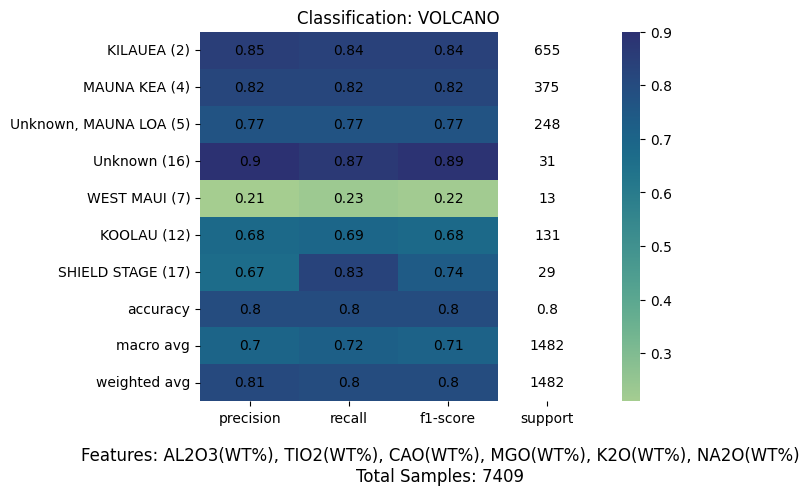

In [48]:
classifier = tree.DecisionTreeClassifier(random_state=69)

def drop_class(data):
    return data.drop([class_ident], axis = 1)

# Separate data into training and testing samples and randomize order
train = primaries.sample(frac=0.8, random_state=69)
test = primaries.drop(train.index)
classifier.fit(drop_class(train), train[:][class_ident])

report = classification_report(
    test[:][class_ident],
    classifier.predict(drop_class(test)),
    target_names = [str(x) for x in primaries[class_ident].unique()],
    labels=primaries[class_ident].unique(),
    zero_division=0,
    output_dict=True
)

def get_caption():
    return f'Features: {", ".join(drop_class(primaries).columns[1:])}\nTotal Samples: {len(primaries.index)}'

def heatmap():
    temp = pd.DataFrame(report).T
    temp = temp.round(2)
    mask = np.zeros((temp.shape[0], temp.shape[1]))
    mask[:,temp.shape[1] - 1] = True
    sns.heatmap(temp, mask=mask, cmap='crest')
    sns.heatmap(temp, annot=True, alpha=0, cbar=False, fmt='.5g', annot_kws={'size': 10, 'color':'black'}).set_title(f'Classification: {class_ident}')
    plt.figtext(0.5, -0.05, get_caption(), wrap=True, horizontalalignment='center', fontsize=12)
    plt.savefig(f'../trees/dt_report-{class_ident}.svg', dpi=300, bbox_inches='tight')

def heatmap_table():
    cm = sns.light_palette("green", as_cmap=True)
    display(pd.DataFrame(report).T.style.background_gradient(cmap=cm))

def display_table():
    final = pd.DataFrame(report).transpose()
    print(f'Classification: {class_ident}')
    display(final.round(2))
    final.round(2).to_csv(f'../trees/dt-{class_ident}.csv')

def plot_tree():
    plt.figure(figsize=(40,20))
    tree.plot_tree(classifier, fontsize=10)

def export_tree():
    dot_data = tree.export_graphviz(
        classifier, 
        out_file=None,
        feature_names=primaries.columns[1:],
        filled=True,
        rounded=True,
        class_names=[str(x) for x in primaries[class_ident].unique()],
    )
    graph = graphviz.Source(dot_data)
    # display(graph)
    graph.format = 'svg'
    graph.render(f'../trees/dt-{class_ident}', view=False, cleanup=True)

heatmap()
export_tree()